### Imports

In [715]:
import numpy as np

import pandas as pd

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer


from matplotlib import pyplot as plt 
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import seaborn as sns

import missingno as mno

import xgboost as xgb

/tmp/ipykernel_756/1756959912.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


### Data Load

In [716]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

### Summarize

In [717]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [718]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [719]:
X_train = train.drop('Transported', axis = 1)
X_test = test
test_PassengerId = test['PassengerId']

y_train = train['Transported']

### Cleaning

Parse PassengerId

In [720]:
def parseID(df):
    group_num = []
    for str in df['PassengerId']:
        group_num.append(int(str.split('_')[0]))
    return pd.Series(group_num).astype('int')

X_train['Group'] = parseID(X_train)
X_test['Group'] = parseID(X_test)

X_train.pop('PassengerId')
X_test.pop('PassengerId')

X_train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,1
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,2
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,3
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,3
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,4


Parse Cabin

In [721]:
def parseCabin(df):
    cabin_deck = []
    cabin_num = []
    cabin_side = []
    for str in df.Cabin:
        if(pd.isna(str)):
            cabin_deck.append(str)
            cabin_num.append(str)
            cabin_side.append(str)
        else:
            cabin_deck.append(str.split("/")[0])
            cabin_num.append(int(str.split("/")[1]))
            cabin_side.append(str.split("/")[2])
    return pd.DataFrame({'CabinDeck' : cabin_deck, 'CabinNum' : cabin_num, 'CabinSide' : cabin_side})

X_train = pd.concat([X_train, parseCabin(X_train)], axis = 1)
X_test = pd.concat([X_test, parseCabin(X_test)], axis = 1)

X_train.pop('Cabin')
X_test.pop('Cabin')

X_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,CabinDeck,CabinNum,CabinSide
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,1,B,0.0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,2,F,0.0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,3,A,0.0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,3,A,0.0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,4,F,1.0,S


Scaling

In [722]:
scaler = StandardScaler()
scaling_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train[scaling_features]), columns = scaling_features)
scaled_X_test = pd.DataFrame(scaler.transform(X_test[scaling_features]), columns = scaling_features)

X_train[scaling_features] = scaled_X_train
X_test[scaling_features] = scaled_X_test

X_train.head()


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,CabinDeck,CabinNum,CabinSide
0,Europa,False,TRAPPIST-1e,0.702095,False,-0.337025,-0.284274,-0.287317,-0.273736,-0.266098,Maham Ofracculy,1,B,0.0,P
1,Earth,False,TRAPPIST-1e,-0.333233,False,-0.173528,-0.278689,-0.245971,0.209267,-0.227692,Juanna Vines,2,F,0.0,S
2,Europa,False,TRAPPIST-1e,2.013510,True,-0.272527,1.934922,-0.287317,5.634034,-0.223327,Altark Susent,3,A,0.0,S
3,Europa,False,TRAPPIST-1e,0.287964,False,-0.337025,0.511931,0.326250,2.655075,-0.097634,Solam Susent,3,A,0.0,S
4,Earth,False,TRAPPIST-1e,-0.885407,False,0.117466,-0.240833,-0.037590,0.223344,-0.264352,Willy Santantines,4,F,1.0,S


In [723]:
X_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,CabinNum
count,8.514000e+03,8.512000e+03,8.510000e+03,8.485000e+03,8.510000e+03,8505.000000,8693.000000,8494.000000
mean,6.217458e-17,-1.419082e-17,-1.669901e-17,5.443168e-18,2.087376e-17,0.000000,4633.389624,600.367671
std,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00,1.000059,2671.028856,511.867226
min,-1.989756e+00,-3.370254e-01,-2.842738e-01,-2.873167e-01,-2.737359e-01,-0.266098,1.000000,0.000000
25%,-6.783417e-01,-3.370254e-01,-2.842738e-01,-2.873167e-01,-2.737359e-01,-0.266098,2319.000000,167.250000
50%,-1.261671e-01,-3.370254e-01,-2.842738e-01,-2.873167e-01,-2.737359e-01,-0.266098,4630.000000,427.000000
75%,6.330730e-01,-2.665267e-01,-2.371097e-01,-2.426636e-01,-2.218284e-01,-0.225946,6883.000000,999.000000
max,3.462968e+00,2.115309e+01,1.821709e+01,3.856422e+01,1.944053e+01,20.798803,9280.000000,1894.000000


Drop 'Name'

In [724]:
X_train.pop('Name')
X_test.pop('Name')

0        Nelly Carsoning
1         Lerome Peckers
2        Sabih Unhearfus
3       Meratz Caltilter
4        Brence Harperez
              ...       
4272         Jeron Peter
4273       Matty Scheron
4274         Jayrin Pore
4275      Kitakan Conale
4276    Lilace Leonzaley
Name: Name, Length: 4277, dtype: object

### Data Visualization

Numerical features

array([[<AxesSubplot: ylabel='Frequency'>,
        <AxesSubplot: ylabel='Frequency'>,
        <AxesSubplot: ylabel='Frequency'>,
        <AxesSubplot: ylabel='Frequency'>],
       [<AxesSubplot: ylabel='Frequency'>,
        <AxesSubplot: ylabel='Frequency'>,
        <AxesSubplot: ylabel='Frequency'>,
        <AxesSubplot: ylabel='Frequency'>]], dtype=object)

/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


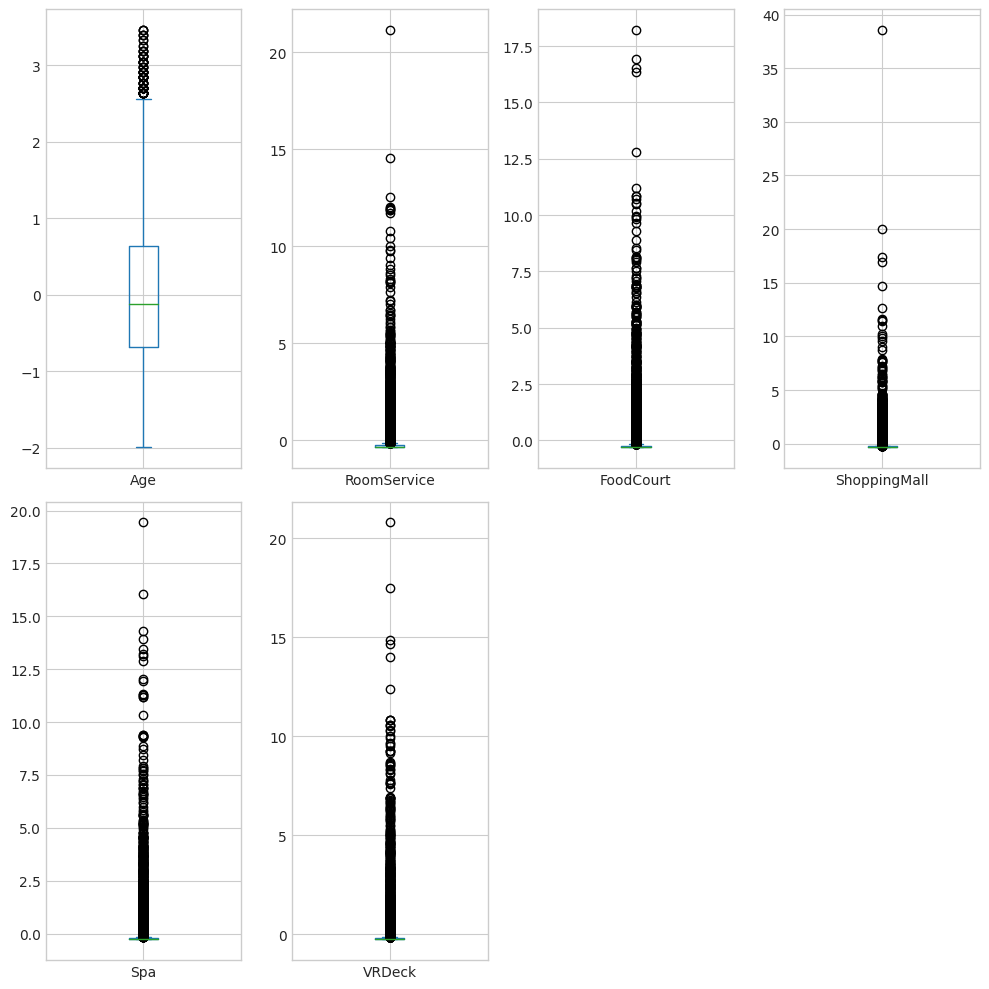

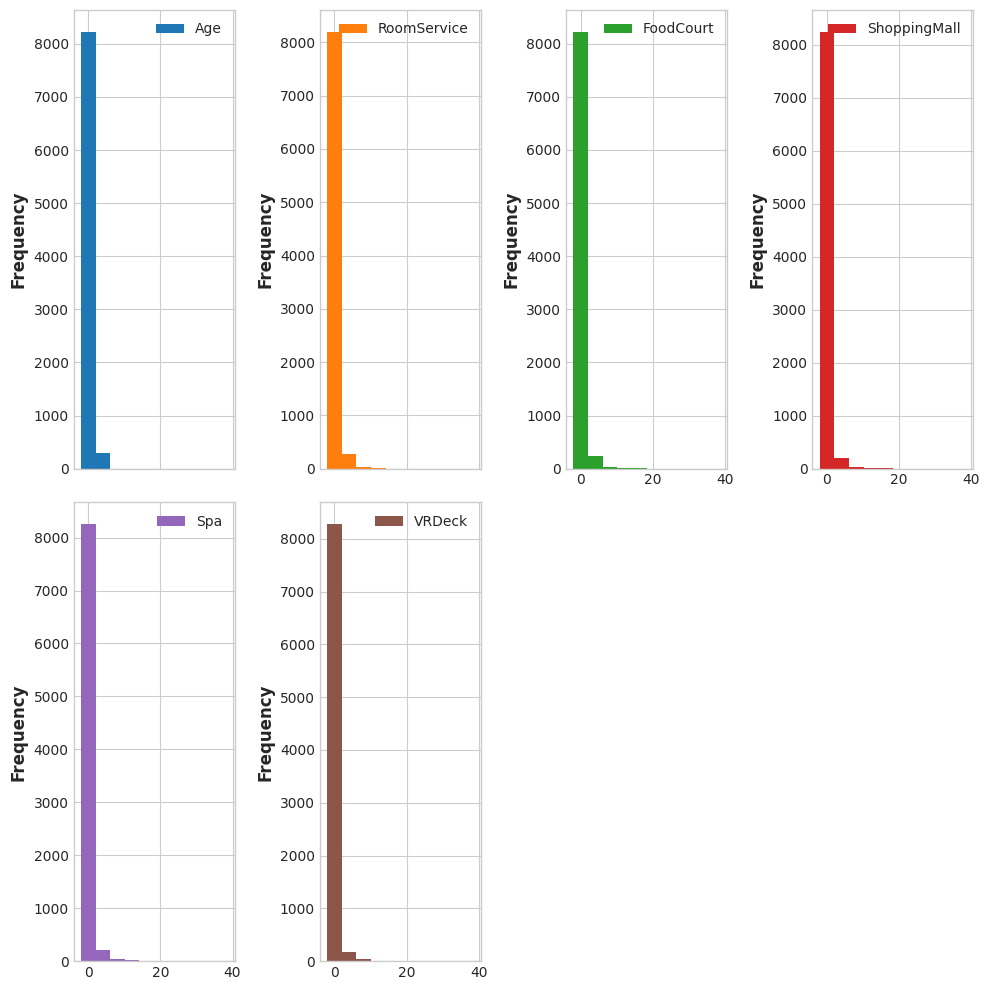

In [725]:
X_train[scaling_features].plot(kind="box", autorange = True, subplots=True, layout=(2,4), figsize=(10,10))
X_train[scaling_features].plot(kind="hist", subplots=True, layout=(2,4), figsize=(10,10))

/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


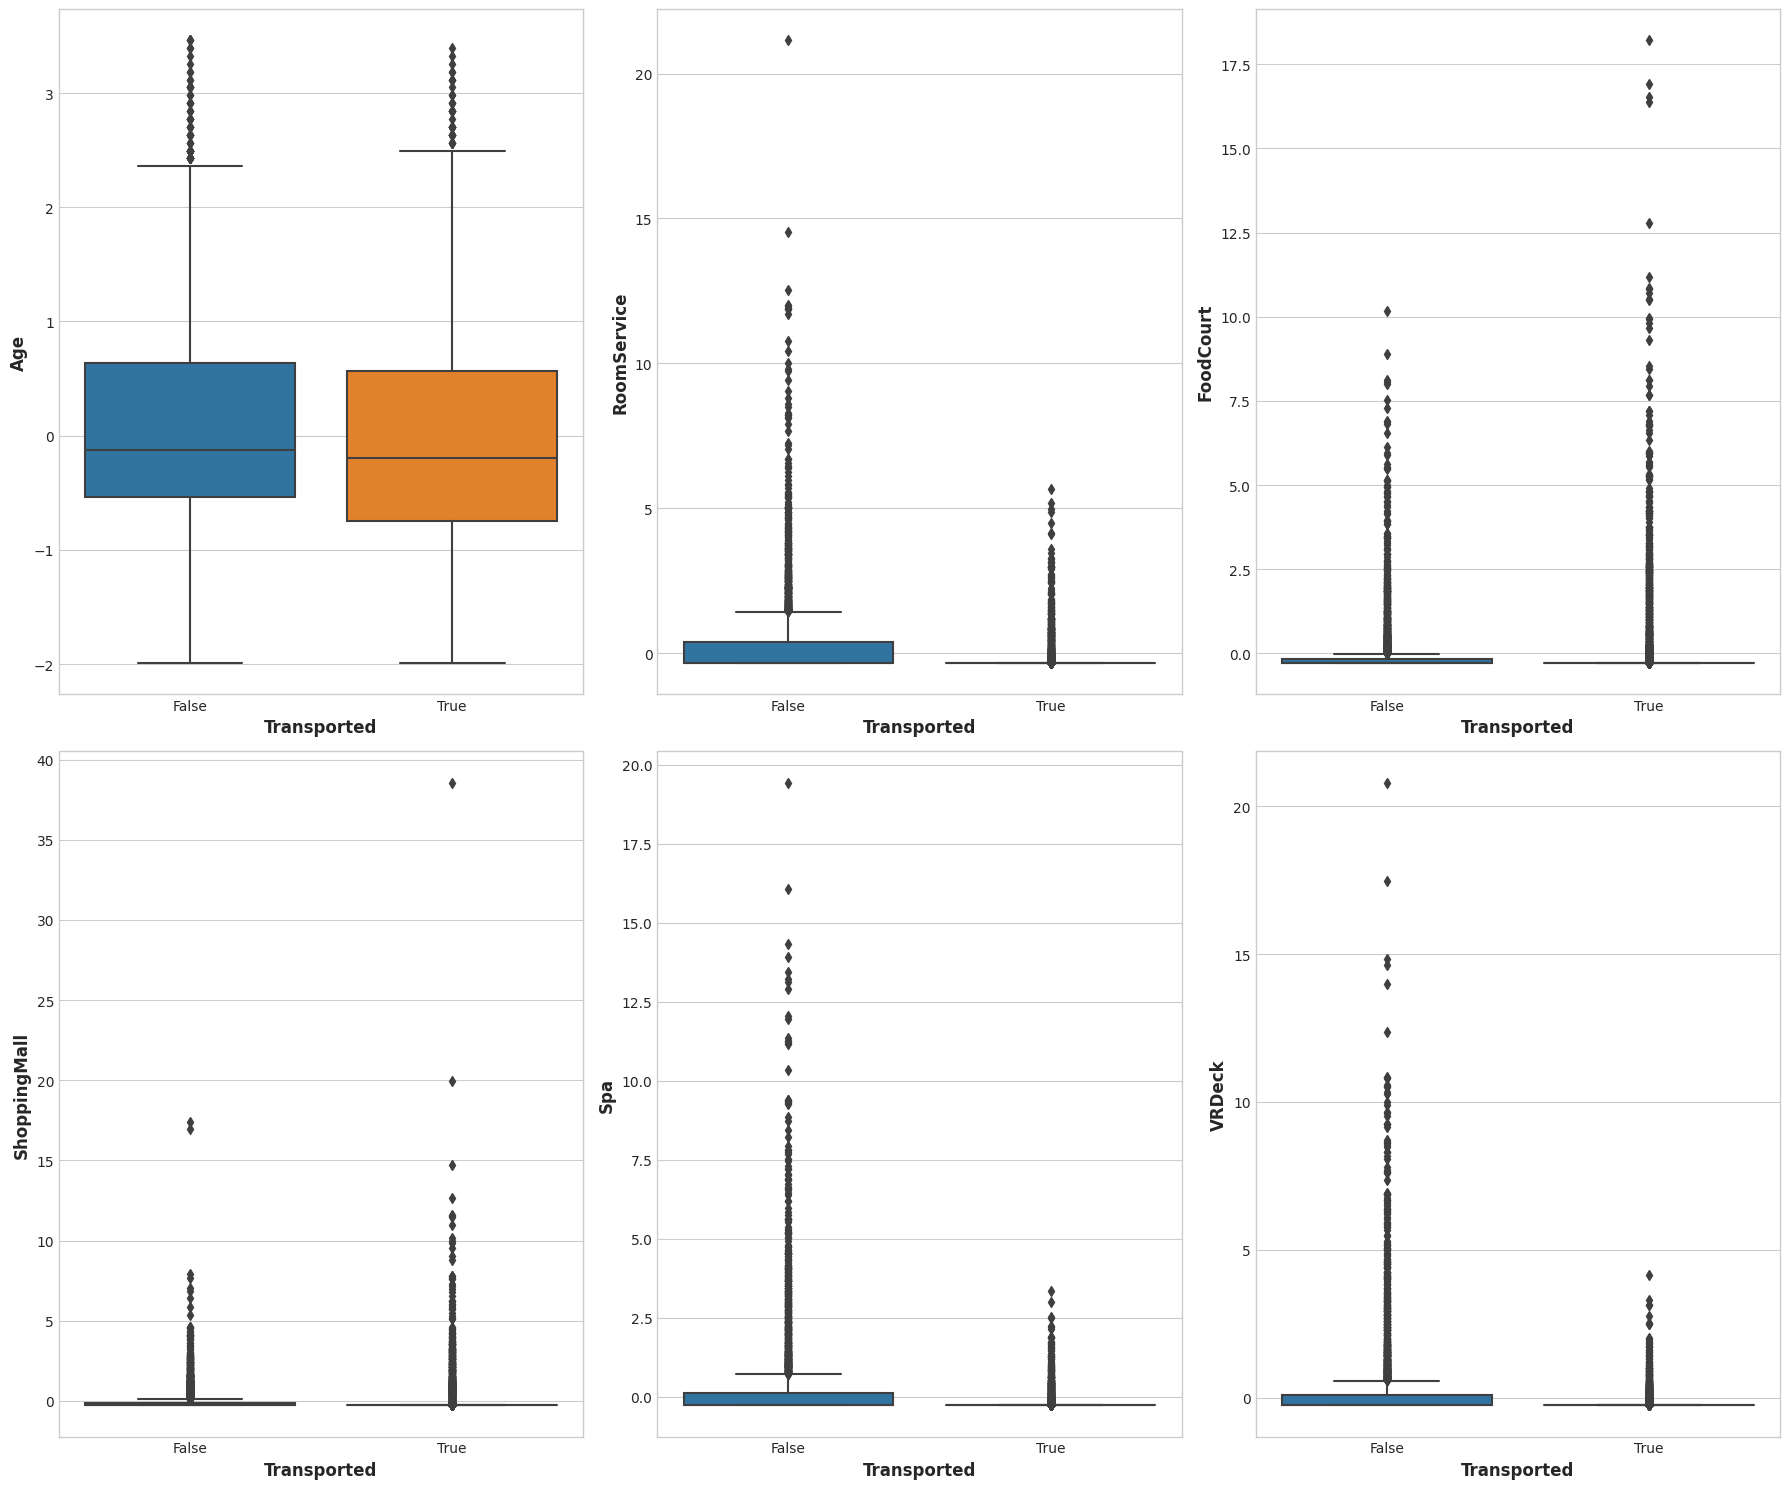

In [726]:
fig, axes = plt.subplots(2, 3,figsize=(18,15))

for name, ax in zip(scaling_features, axes.flatten()):
    sns.boxplot(y = name, x = 'Transported', data = pd.concat([X_train, y_train], axis=1), ax = ax)

Categorical features

/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


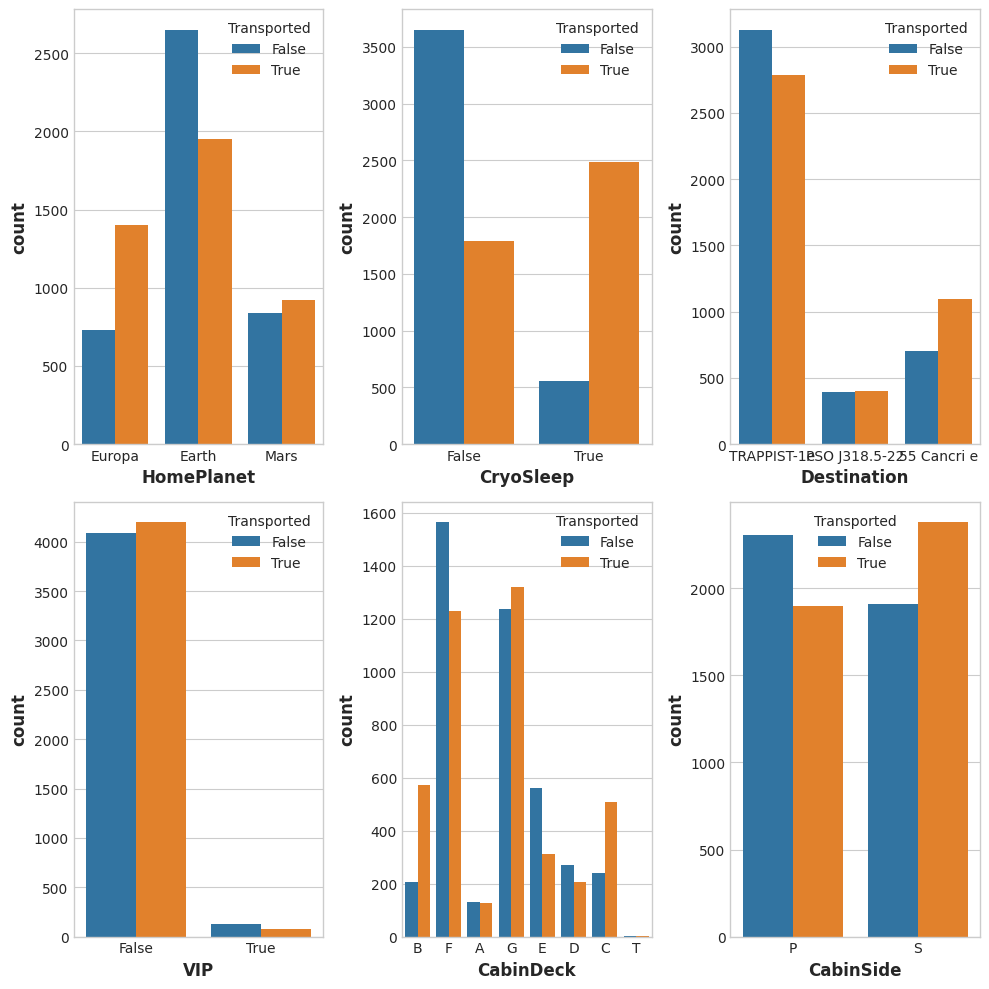

In [727]:
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
names = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck', 'CabinSide']

for name, ax in zip(names, axes.flatten()):
    sns.countplot(x=name, data=pd.concat([X_train, y_train], axis=1), ax=ax, hue='Transported')

### Handling missing values

In [728]:
X_train['CryoSleep'] = X_train['CryoSleep'].astype('bool')
X_test['CryoSleep'] = X_test['CryoSleep'].astype('bool')

In [729]:
num_features = X_train.select_dtypes('number').columns
cat_features = X_train.select_dtypes('object').columns

In [730]:
X_train.isna().sum() / X_train.shape[0]

HomePlanet      0.023122
CryoSleep       0.000000
Destination     0.020936
Age             0.020591
VIP             0.023352
RoomService     0.020821
FoodCourt       0.021051
ShoppingMall    0.023927
Spa             0.021051
VRDeck          0.021627
Group           0.000000
CabinDeck       0.022892
CabinNum        0.022892
CabinSide       0.022892
dtype: float64

<AxesSubplot: >

/root/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)


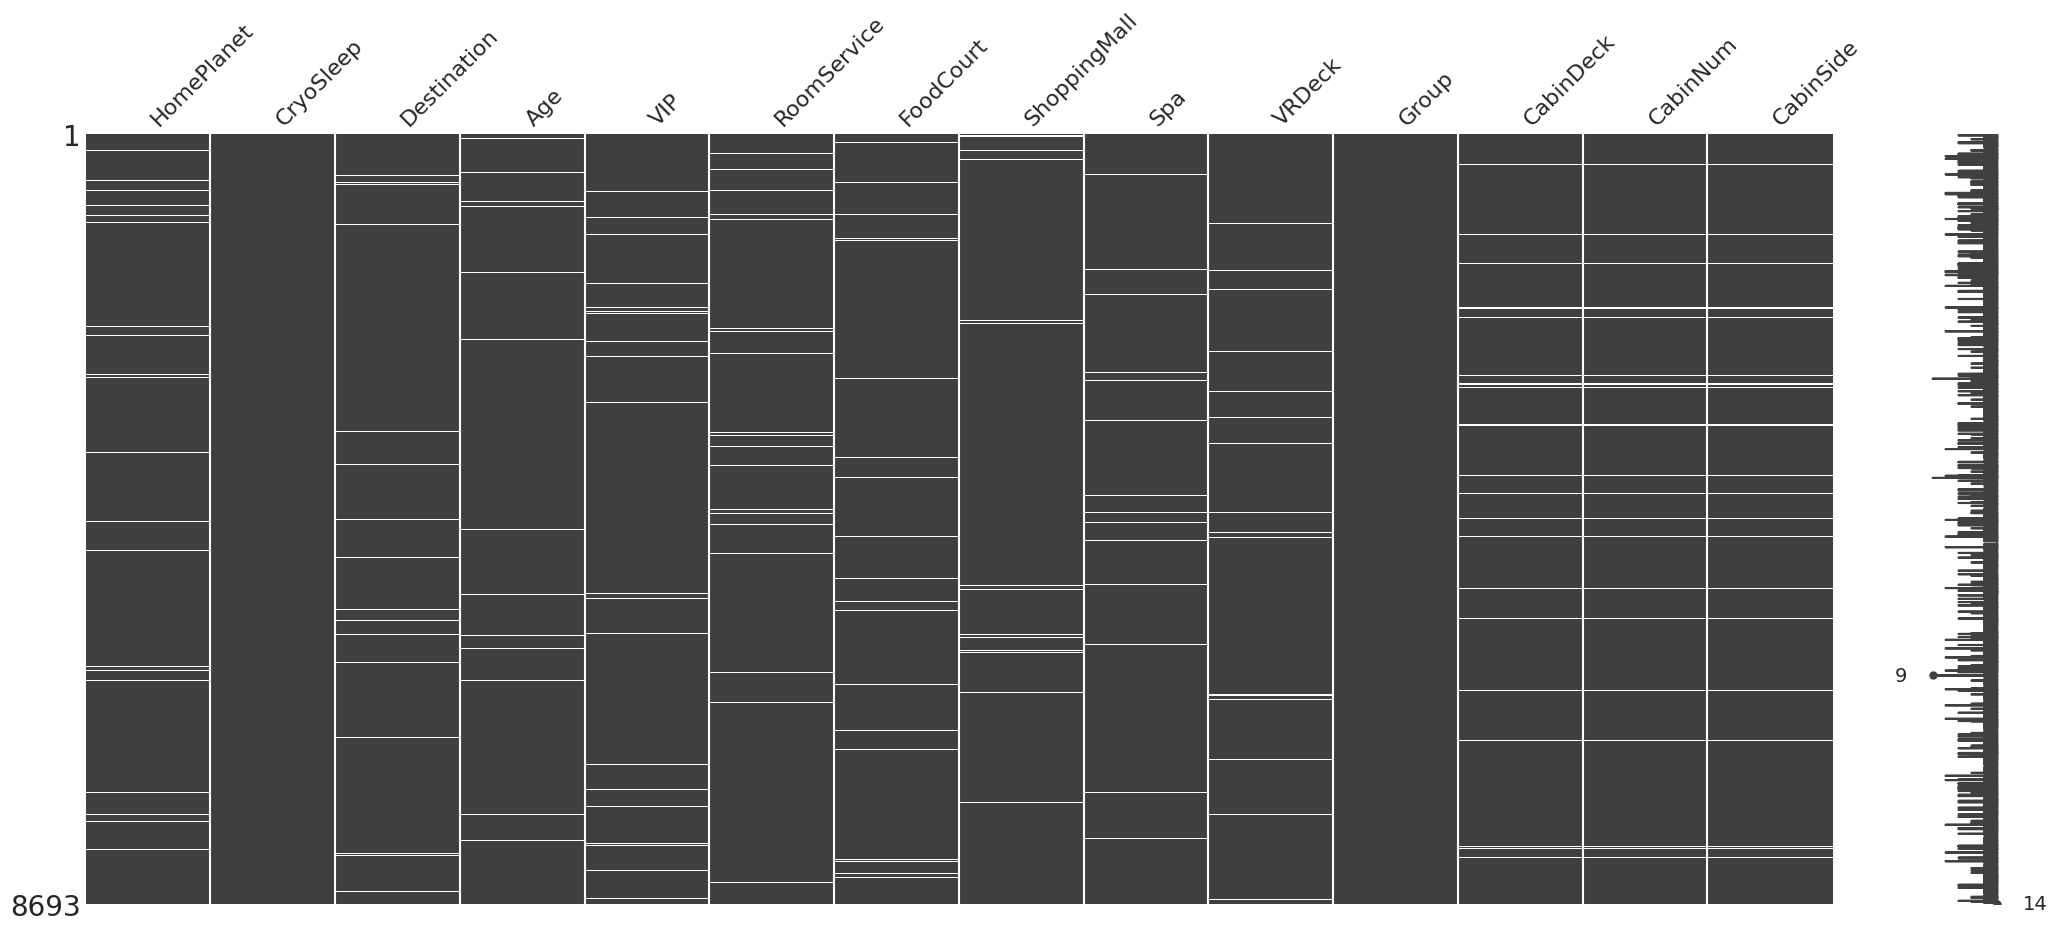

In [731]:
mno.matrix(X_train)

In [732]:
num_imput = SimpleImputer(missing_values = np.nan, strategy = 'mean')
X_train[num_features] = num_imput.fit_transform(X_train[num_features])
X_test[num_features] = num_imput.transform(X_test[num_features])

In [733]:
for feature in cat_features:
    print('{0}: {1}'.format(feature, len(X_train[feature].unique())))

HomePlanet: 4
Destination: 4
VIP: 3
CabinDeck: 9
CabinSide: 3


In [734]:
cat_imput = SimpleImputer(strategy = 'most_frequent')
X_train[cat_features] = cat_imput.fit_transform(X_train[cat_features])
X_test[cat_features] = cat_imput.transform(X_test[cat_features])

In [735]:
X_train.isna().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Group           0
CabinDeck       0
CabinNum        0
CabinSide       0
dtype: int64

### Encode

In [736]:
X_train = pd.concat([X_train, pd.get_dummies(X_train[cat_features], prefix=cat_features)], axis=1)
X_test = pd.concat([X_test, pd.get_dummies(X_test[cat_features], prefix=cat_features)], axis=1)

X_train = X_train.drop(cat_features, axis=1)
X_test = X_test.drop(cat_features, axis=1)

X_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  8693 non-null   bool   
 1   Age                        8693 non-null   float64
 2   RoomService                8693 non-null   float64
 3   FoodCourt                  8693 non-null   float64
 4   ShoppingMall               8693 non-null   float64
 5   Spa                        8693 non-null   float64
 6   VRDeck                     8693 non-null   float64
 7   Group                      8693 non-null   float64
 8   CabinNum                   8693 non-null   float64
 9   HomePlanet_Earth           8693 non-null   uint8  
 10  HomePlanet_Europa          8693 non-null   uint8  
 11  HomePlanet_Mars            8693 non-null   uint8  
 12  Destination_55 Cancri e    8693 non-null   uint8  
 13  Destination_PSO J318.5-22  8693 non-null   uint8

In [737]:
X_train[X_train.select_dtypes('uint8').columns] = X_train.select_dtypes('uint8').astype('int')
X_test[X_test.select_dtypes('uint8').columns] = X_test.select_dtypes('uint8').astype('int')
X_train[['Group', 'CabinNum']] = X_train[['Group', 'CabinNum']].astype('int')
X_test[['Group', 'CabinNum']] = X_test[['Group', 'CabinNum']].astype('int')
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  8693 non-null   bool   
 1   Age                        8693 non-null   float64
 2   RoomService                8693 non-null   float64
 3   FoodCourt                  8693 non-null   float64
 4   ShoppingMall               8693 non-null   float64
 5   Spa                        8693 non-null   float64
 6   VRDeck                     8693 non-null   float64
 7   Group                      8693 non-null   int64  
 8   CabinNum                   8693 non-null   int64  
 9   HomePlanet_Earth           8693 non-null   int64  
 10  HomePlanet_Europa          8693 non-null   int64  
 11  HomePlanet_Mars            8693 non-null   int64  
 12  Destination_55 Cancri e    8693 non-null   int64  
 13  Destination_PSO J318.5-22  8693 non-null   int64

### Feature selection

In [738]:
X_train = X_train.drop(['Group', 'CabinNum'], axis=1)
X_test = X_test.drop(['Group', 'CabinNum'], axis=1)

In [739]:
discrete_features = X_train.dtypes == 'int'
mi_scores = mutual_info_regression(X_train, y_train, discrete_features=discrete_features, random_state=0)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train.columns)
mi_scores = mi_scores.sort_values(ascending=True)
mi_scores

CabinDeck_G                  0.000000
CabinDeck_D                  0.000937
HomePlanet_Mars              0.001047
CabinDeck_T                  0.001559
Destination_PSO J318.5-22    0.001702
CabinDeck_A                  0.002655
VIP_True                     0.003381
VIP_False                    0.003381
Age                          0.005360
CabinDeck_F                  0.006447
Destination_TRAPPIST-1e      0.007418
CabinDeck_E                  0.007597
Destination_55 Cancri e      0.010206
CabinSide_S                  0.010399
CabinSide_P                  0.010399
HomePlanet_Earth             0.011361
CabinDeck_C                  0.011534
CabinDeck_B                  0.012455
HomePlanet_Europa            0.016510
FoodCourt                    0.053544
ShoppingMall                 0.057487
VRDeck                       0.060413
Spa                          0.066619
RoomService                  0.079703
CryoSleep                    0.102873
Name: MI Scores, dtype: float64

Text(0.5, 1.0, 'Mutual Information Scores')

/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


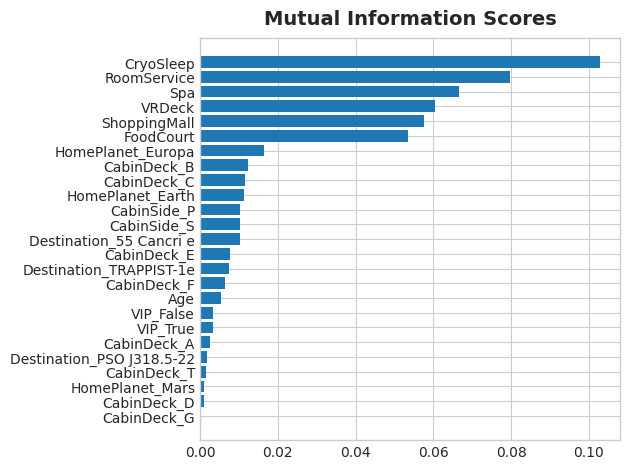

In [740]:
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.barh(width, mi_scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")

In [741]:
# threshold 0 : 0.8021 / 0.001 : 0.8029 / 0.005: 0.8027
drop_features = mi_scores[mi_scores < 0].index
X_train = X_train.drop(drop_features, axis=1)
X_test = X_test.drop(drop_features, axis=1)

### Modeling and Scoring

In [742]:
model = xgb.XGBClassifier(
    learning_rate = 0.03,
    n_estimators = 300,
    max_depth = 5
)
def score_dataset(X, y, model=model):
    score = cross_val_score(
        model, X, y, cv=5, scoring="accuracy",
    )
    return score.mean()

print(score_dataset(X_train, y_train))

0.8021416220715979


### Submission

In [743]:
model.fit(X_train, y_train)
y_test = model.predict(X_test) == 1
submission = pd.DataFrame(y_test, columns=['Transported'])
submission = pd.concat([test_PassengerId, submission], axis=1)
submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [744]:
submission.to_csv('./submission.csv', index=False)